### Quantum Neural Network

In [17]:
from qiskit_machine_learning.utils import algorithm_globals

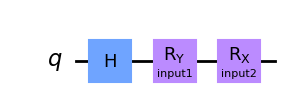

In [2]:
'''
파라미터 클래스를 사용해서, quantum circuit에서 gate의 파라미터를 정의할 수 있다.

이 parameter에는 circuit을 동작하기 전에 특정 값을 할당할 수 있다.
'''
from qiskit.circuit import Parameter


from qiskit import QuantumCircuit

# input1 과 input2는 parameter로 나중에 값을 할당할 수 있다.
params1 = [Parameter("input1"), Parameter("input2")] 

qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl", style = "clifford")



In [4]:
# sparsepauliop는 실제 양자 시스템에서 사용되는 연산자가 전체 파울리 기저의 극히 일부 항으로 표현되는 경우가 많다는 점을 이용하여, 
# 불필요한 0 값들을 저장하거나 계산하지 않음으로써 메모리와 연산 효율을 크게 향상시킵니다. 
# 이러한 특성 때문에 대규모 양자 시스템이나 해밀토니안 시뮬레이션에서 매우 유용하게 사용됩니다.

# SparsePauliOp는 주어진 circuit의 행렬을 pauli operator의 선형결합으로 표현해줍니다.
# 이때, 대부분의 기저들의 계수가 0이라서, sparse = 희소하다 라는 말이 붙었습니다.

from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([ ("Y" * qc1.num_qubits , 1 )  ])
'''
SparsePauliOp.from_list 는 튜플로 이루어진 리스트를 받아서, 계수와 pauli string을 만듭니다.

즉, [  ("YYY", 1) , ("ZZZ", 2) ] 이런식으로 만들어진 리스트를 받으면,
Y1 * Y2 * Y3 + 2* Z1 * Z2 * Z3 이런식으로 만들어집니다.
'''


'\nSparsePauliOp.from_list 는 튜플로 이루어진 리스트를 받아서, 계수와 pauli string을 만듭니다.\n\n즉, [  ("YYY", 1) , ("ZZZ", 2) ] 이런식으로 만들어진 리스트를 받으면,\nY1 * Y2 * Y3 + 2* Z1 * Z2 * Z3 이런식으로 만들어집니다.\n'

##### EstimatorQNN 사용해서, 주어진 circuit의 벡터에 대한 기댓값 구하기.

EstimatorQNN 은 주어진 양자역학적 observable에 대한 기댓값을, circuit의 결과벡터를 통해 구합니다.

즉, 내가 정의한 observable = "XXX" 에 대한, 기댓값 
$\braket{\psi | XXX | \psi}$ 를 출력합니다.

<br><br>
__EstimatorQNN은 다음과 같은 keyword argument를 필요로합니다.__
<br><br>
(1) estimator  : 그냥 primitive 인스턴스임
<br><br>
(2) pass_manager : 패스매니저는 transipile 필요한 circuit이 많아질때 관리해주는 인스턴스
<br><br>
(3) input_params : QNN에 입력 데이터
<br><br>
(4) weight_params : QNN에서 최적화할 가중치 값



In [8]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

# 내 circuit의 결과벡터를 통해서, 어떻게 observable에 대한 기댓값을 구할것인지를 구성함.
estimator_qnn = EstimatorQNN(
    circuit = qc1,
    observables = observable1,
    input_params = [params1[0]],
    weight_params = [params1[1]],
    estimator = estimator,
)

estimator_qnn


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


### How to run a forward pass for QNN

인공신경망구축축에서 중요한것은 forward pass를 어떻게 정의하는냐 즉, 레이어를 어떻게 쌓을 것이냐 
이다.

이번 내용에서는 quantum circuit에서 어떻게 forward pass를 정의할 것인지를 살펴보자.

##### * qiskit_machine_learning.utils.algorithm_globals 모듈

Qiskit에서 이 모듈은 일반적인 양자알고리즘을 설계하는데 있어서 global한 세팅을하는데 도움을 주는역할을 한다. 주로, random 한 수를 생성하거나, gloabl setting 기능을 한다.
( VQA, Monte Carlo 등에서 사용됨)

In [20]:
'''
EstimatorQNN 클래스스의 인스턴스에

random.random() 함수를 사용해서, input과 weight를 attribute에 저장한다.

algorithm_globals.random 에는 여러가지 random 함수들이 정의되어 있다.

random.random() 함수는 0과 1사이의 랜덤한 값을 반환한다.
random.uniform(a, b) 함수는 a와 b사이의 랜덤한 값을 반환한다.
random.normal(mu, sigma) 함수는 평균이 mu이고 표준편차가 sigma인 정규분포에서 랜덤한 값을 반환한다.
등등..
'''
algorithm_globals.random_seed = 42


'''
This generates an array of random numbers with a length equal to num_inputs. 
Each number in the array is a random float between 0 and 1.

estimator_qnn 인스턴스에는 2가지의 parameter가 정의되어 있다.
params1[0] : input parameter
params1[1] : weight parameter

즉, 이 인스턴스의 attribute num_inputs는 1이고, num_weights는 각각 1로 정의되어 있다.
'''
estimator_qnn_input = algorithm_globals.random.random(estimator_qnn.num_inputs)
estimator_qnn_weight = algorithm_globals.random.random(estimator_qnn.num_weights)

print(
    f"Number of input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {estimator_qnn_input}"
)
print(
    f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {estimator_qnn_weight}"
)


Number of input features for EstimatorQNN: 1 
Input: [0.77395605]
Number of trainable weights for EstimatorQNN: 1 
Weights: [0.43887844]
